<a href="https://colab.research.google.com/github/datasigntist/deeplearning/blob/master/Experiments_with_RNN_Generating_Lyrics_for_a_song_by_an_Artist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Experiments with RNN -- Generating Lyrics for a song by an Artist**

**Author**: Vishwanathan Raman
**Email**: datasigntist@gmail.com


---


**Change History**


*   9-Sep-2019 -- Initial Creation


---

**Credits**
The code articulated here has been inspired from coursera deeplearning.ai Assignments


---

**Use Case Description**

This notebook develops a Recurrent Neural Network to generate lyrics of song using a seed, based on the history of songs done by the artist Bruce Springsteen.

The following is the source of the dataset https://www.kaggle.com/mousehead/songlyrics

The following is the video articulating the concepts
https://www.youtube.com/playlist?list=PLkEQhv7sdYRLeBn_a5EaXdLBPEp0zASsx


---


**Other Learning Resources**

The following youtube playlist lists all the concepts related to Deep Learning 


*   https://www.youtube.com/watch?v=yEfsDHymL0w&list=PLZnyIsit9AM7yeTZuBmezKNc6hFHUPImh
*   https://www.youtube.com/watch?v=YgpI2aROLlo&list=PLZnyIsit9AM7HBPn6m06ddzw_N9zGk--2
*   https://www.youtube.com/watch?v=186rxP6qfJA&list=PLZnyIsit9AM7VI4ylALdbeS93i-nonUzZ

**Articles on Embedding**
*   https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/





# **Tensorflow Installation (Optional)**

This experiment is built on tensorflow 2.0 gpu, run a quick check to see the current version, if its not 2.0 then uninstall the current version and install the 2.0 gpu version

In [0]:
import tensorflow as tf
print(tf.__version__)

1.15.0-rc3


In [0]:
!pip uninstall tensorflow

Uninstalling tensorflow-1.15.0rc3:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/freeze_graph
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-1.15.0rc3.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0rc3


In [0]:
!pip install tensorflow-gpu

     |████████████████████████████████| 380.8MB 82kB/s 
     |████████████████████████████████| 3.8MB 27.1MB/s 
     |████████████████████████████████| 450kB 45.0MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


# **Importing Libraries and setting Global Variables**

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 
import zipfile

In [0]:
artistName = "Bruce Springsteen"

# **Dataset**

The dataset is sourced from https://www.kaggle.com/mousehead/songlyrics . Its a compilation of 57650 songs by various artists. As part of the experiment, we are going to pick an artist by name "Bruce Springsteen" (https://en.wikipedia.org/wiki/Bruce_Springsteen), crawl his songs, build a RNN model and generate new lyrics using a seed text if he were to sing a new song. I recently happened to watch the movie  "Blended by the Light" (https://en.wikipedia.org/wiki/Blinded_by_the_Light_(2019_film)) on netflix which has Bruce Springsteen play the insipration role. On a personal note I loved his rendering of "Born In the USA" so decided to pick the BOSS as the artist for analysis.

In [0]:
# Downloading the data from github
!wget --no-check-certificate "https://github.com/datasigntist/datasetsForTraining/raw/master/songlyrics.zip" -O "/tmp/songlyrics.zip"
  
local_zip = '/tmp/songlyrics.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2019-10-10 06:43:17--  https://github.com/datasigntist/datasetsForTraining/raw/master/songlyrics.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/datasigntist/datasetsForTraining/master/songlyrics.zip [following]
--2019-10-10 06:43:17--  https://raw.githubusercontent.com/datasigntist/datasetsForTraining/master/songlyrics.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21988108 (21M) [application/zip]
Saving to: ‘/tmp/songlyrics.zip’

/tmp/songlyrics.zip 100%[===================>]  20.97M   102MB/s    in 0.2s    

2019-10-10 06:43:18 (102 MB/s) - ‘/tmp/songlyrics.zip’ saved [21988108/21988108

In [0]:
import pandas as pd

# Read the data file
songdata = pd.read_csv('/tmp/songdata.csv')

In [0]:
# Browse the data

songdata.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [0]:
# Filter the dataset by all songs by Artist

songsByArtist = songdata[songdata["artist"]==artistName]

In [0]:
# Browse the songs by Artist

songsByArtist.head()

,artist,song,link,text
2002,Bruce Springsteen,30 Days Out,/b/bruce+springsteen/30+days+out_20025285.html,We fell in love and I made you the world \nI ...
2003,Bruce Springsteen,Action In The Streets,/b/bruce+springsteen/action+in+the+streets_200...,Well don't move \nWhy don't you listen to wha...
2004,Bruce Springsteen,All I'm Thinkin' About,/b/bruce+springsteen/all+im+thinkin+about_1005...,Blind man wavin' by the side of the road \nI'...
2005,Bruce Springsteen,All Night Long,/b/bruce+springsteen/all+night+long_10052078.html,I was born saved in heaven \nIt was nothing l...
2006,Bruce Springsteen,All That Heaven Will Allow,/b/bruce+springsteen/all+that+heaven+will+allo...,I got a dollar in my pocket \nThere ain't a c...


In [0]:
# Browse the songs by Artist 

print("Total number of songs by ", artistName, ":",songsByArtist.shape[0])

Total number of songs by  Bruce Springsteen : 175


## **Compile all the songs of Bruce Springsteen into 1 single list**

Compile all the songs of Bruce Springsteen into 1 single list. In the process

*   Get rid of words like [chorus:] that do not mean anything
*   Strip the empty sapces, remove any empty lines and get rid of specical characters like "(" , ")" , "\", "/" , ".", ",",":"






In [0]:
stopWords = ["(",")","/","\\",".",",",":",'"']
wordsTobeRemoved = ["[chorus:]"]

In [0]:
# Prepare the dataset

databyArtist = "\n".join(songsByArtist["text"])

In [0]:
corpus = databyArtist.lower().split("\n")

In [0]:
corpus[0:10]

['we fell in love and i made you the world  ',
 "i spent all my time tryin' to satisfy you, girl  ",
 "just one thing that i can't figure out  ",
 'closer i get, farther baby i am out  ',
 '  ',
 '30 days, 30 days out  ',
 "well i'm six days runnin' but i'm 30 days out  ",
 '30 days, 30 days out  ',
 'with every kiss you leave a little shadow of doubt  ',
 '  ']

In [0]:
for loop in range(len(wordsTobeRemoved)):
  corpus = [line.replace(wordsTobeRemoved[loop],"") for line in corpus]

In [0]:
for loop in range(len(stopWords)):
  print(stopWords[loop])
  corpus = [line.replace(stopWords[loop],"") for line in corpus]

(
)
/
\
.
,
:
"


In [0]:
corpus = [elem.strip() for elem in corpus if elem.strip()!=""]

In [0]:
print("Total number of lines : ",len(corpus))

Total number of lines :  5788


# Processing the data using tensorflow

## **Applying Tokenizer**

The fit_on_text function takes the corpus as the input, breaks the corpus into invidual words and assigns an unique number to each of the words. OOV or Out of Vocabulary is assigned for missing words. For each line in the corpus tokenizer generate a sequence of numbers through texts_to_sequences. The number for a specific word reflects what was generated in the previous step through fit_on_texts. 

For example if the sentence was "Shyam is a good boy", the texts_to_sequences generates an equivalent sequence like "1234 45 48 90 1220".

Here 
*   1234 is a representation for "Shyam"
*   45 is a representation for "is"
*   48 is a representation for "a"
*   90 is a representation for "good"
*   1220 is a representation for "boy"

Each line in the corpus is processed to generate a sequence of numbers as explained above.

In [0]:
tokenizer = Tokenizer(oov_token="OOV")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [0]:
print("Total number of words", total_words)

Total number of words 4221


In [0]:
# Reverse the word index
reverseWordIndex = {v: k for k, v in tokenizer.word_index.items()}

## **Generating n-gram sequence**

In addition to the above step for each sequence, a ngram sequence is generated using the numbers, for instance

*   Shyam is
*   Shyam is a 
*   Shyam is a good 
*   Shyam is a good boy

Here words are being used here for illustration purposes. Ideally the words are represented by numbers.


In [0]:
input_sequences = []
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  for i in range(1,len(token_list)):
    n_gram_sequence = token_list[:i+1]
    input_sequences.append(n_gram_sequence)

In [0]:
print("Total number of generated sequences ",len(input_sequences))

Total number of generated sequences  37630


In [0]:
input_sequences[0:4]

[[27, 309], [27, 309, 8], [27, 309, 8, 37], [27, 309, 8, 37, 4]]

In [0]:
print(reverseWordIndex[27],' ',reverseWordIndex[309],' ',reverseWordIndex[8],' ',reverseWordIndex[37])

we   fell   in   love


## **Padding the Sequence to maximum length**

In [0]:
max_len_sequence = max([len(x) for x in input_sequences])

In [0]:
print("Maximum length of sequence is ", max_len_sequence)

Maximum length of sequence is  18


The ngram sequence generated in the previous step is of differing lengths. In order to compile them as single matrix, its essential to pad them with 0s. The shape of the matrix is equated to the length of the maximum sequence. Lets take the previous example 

*   Shyam is
*   Shyam is a 
*   Shyam is a good 
*   Shyam is a good boy

Assuming thats the only line the max length is 5 words hence each entry is padded with 0 to fill in the remaining pieces

*   **0 0 0** Shyam is
*   **0 0** Shyam is a 
*   **0** Shyam is a good 
*   Shyam is a good boy

As you can see all the sequences are padded to the same length. The words being used here is for illustration purposes. Ideally the words are represented by numbers as shown in the below step.


In [0]:
input_sequences = np.array(pad_sequences(input_sequences,maxlen=max_len_sequence,padding="pre"))

In [0]:
# Get a glimpse of padded sequences
print(input_sequences)

[[  0   0   0 ...   0  27 309]
 [  0   0   0 ...  27 309   8]
 [  0   0   0 ... 309   8  37]
 ...
 [  0   0   0 ... 515  30   3]
 [  0   0   0 ...  30   3  36]
 [  0   0   0 ...   3  36 728]]


## **Defining the input and the labels**

Now that the sequences have been made uniform in length, its time to split the data into X and labels. Here the label is the last datapoint in the sequence and everything else is X.  

In [0]:
xs = input_sequences[:,:-1]
labels = input_sequences[:,-1]

In [0]:
# View the X
print(xs)
# View the labels
print(labels)

[[  0   0   0 ...   0   0  27]
 [  0   0   0 ...   0  27 309]
 [  0   0   0 ...  27 309   8]
 ...
 [  0   0   0 ...   3 515  30]
 [  0   0   0 ... 515  30   3]
 [  0   0   0 ...  30   3  36]]
[309   8  37 ...   3  36 728]


## **Converting the labels to one hot encoding**

The labels identified in the last step is converted to a one hot encoding through the function to_categorical. The length of the one hot encoding is equivalent to the total number of words.

In [0]:
ys = tf.keras.utils.to_categorical(labels,num_classes=total_words)

In [0]:
# Print the one hot encoding
print(ys)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
np.argmax(ys[0])
print(ys[0][309])

1.0


## **Building the model**

In [0]:
embeddingSize = 500
nodeCount = 150

In [0]:
model = Sequential()
model.add(Embedding(total_words, embeddingSize, input_length=max_len_sequence-1))
model.add(Bidirectional(LSTM(nodeCount, return_sequences = True)))
model.add(Bidirectional(LSTM(nodeCount, return_sequences = True)))
model.add(LSTM(nodeCount))
model.add(Dense(total_words, activation='relu'))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 500)           2110500   
_________________________________________________________________
bidirectional (Bidirectional (None, 17, 300)           781200    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 17, 300)           541200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               270600    
_________________________________________________________________
dense (Dense)                (None, 4221)              637371    
_________________________________________________________________
dense_1 (Dense)              (None, 4221)              17821062  
Total params: 22,161,933
Trainable params: 22,161,933
Non-trainable params: 0
____________________________________________

## **Embedding Analysis**

In [0]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)
word_index = tokenizer.word_index

(4221, 500)


In [0]:
happy_key = word_index["happy"]
happy_word = reverseWordIndex[happy_key]
print("Key for Happy is :", happy_key)
happy_embeddings = weights[happy_key]
print('Embeddings for Happy is :-->\n', happy_embeddings.shape)

Key for Happy is : 287
Embeddings for Happy is :-->
 (500,)


In [0]:
glad_key = word_index["glad"]
glad_word = reverseWordIndex[glad_key]
print("Key for Glad is :", glad_key)
glad_embeddings = weights[glad_key]
print('Embeddings for Glad is :-->\n', glad_embeddings.shape)

Key for Glad is : 1569
Embeddings for Glad is :-->
 (500,)


In [0]:
sad_key = word_index["sad"]
sad_word = reverseWordIndex[sad_key]
print("Key for sad is :", sad_key)
sad_embeddings = weights[sad_key]
print('Embeddings for sad is :-->\n', sad_embeddings.shape)

Key for sad is : 487
Embeddings for sad is :-->
 (500,)


## **Training, Accuracy and Loss**

In [0]:
 history = model.fit(xs, ys, epochs=100, verbose=1)

Train on 37630 samples
Epoch 1/25
37630/37630 [==============================] - 97s 3ms/sample - loss: 0.6116 - accuracy: 0.8216
Epoch 2/25
37630/37630 [==============================] - 98s 3ms/sample - loss: 0.6263 - accuracy: 0.8188
Epoch 3/25
37630/37630 [==============================] - 98s 3ms/sample - loss: 0.6006 - accuracy: 0.8251
Epoch 4/25
37630/37630 [==============================] - 98s 3ms/sample - loss: 0.6012 - accuracy: 0.8254
Epoch 5/25
37630/37630 [==============================] - 98s 3ms/sample - loss: 0.6071 - accuracy: 0.8228
Epoch 6/25
37630/37630 [==============================] - 98s 3ms/sample - loss: 0.6116 - accuracy: 0.8232
Epoch 7/25
37630/37630 [==============================] - 98s 3ms/sample - loss: 0.6060 - accuracy: 0.8235
Epoch 8/25
37630/37630 [==============================] - 99s 3ms/sample - loss: 0.6028 - accuracy: 0.8242
Epoch 9/25
37630/37630 [==============================] - 98s 3ms/sample - loss: 0.6079 - accuracy: 0.8226
Epoch 10/25
37

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history,string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

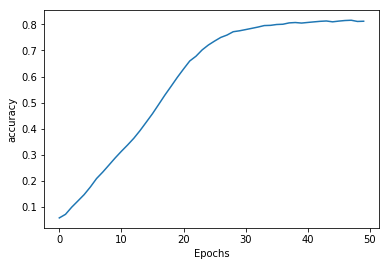

In [0]:
plot_graphs(history,'accuracy')

## **Predict using the trained model**

Its time to predict the next sequence of words. Here lets assume that the seed text to be "We loved". Lets see what our model predicts the next 200 words to be. 

The seed text is preprocessed, padded and used as the input to predict the next word. Once predicted its concatenated to the original seed text and the next prediction is made. This sequence is repeated for 200 times.

In [0]:
songsByArtist = songsByArtist.reset_index()

In [0]:
minLengthOfASong = int(np.min([len(songsByArtist["text"][key].split("\n")) for key in range(songsByArtist.shape[0])]))
print("Min Length of a Song :",minLengthOfASong,' lines')

Min Length of a Song : 17  lines


In [0]:
allSongDataByArtist = [songsByArtist["text"][key].split("\n") for key in range(songsByArtist.shape[0])]

In [0]:
wordsByLines = []
for loop1 in range(len(allSongDataByArtist)):
  for loop2 in range(minLengthOfASong):
    if (loop1 == 0):
      wordsByLines.append(len([elem.strip() for elem in allSongDataByArtist[loop1][loop2].split(" ") if elem.strip()!=""]))
    else:
      wordsByLines[loop2] = (wordsByLines[loop2]+len([elem.strip() for elem in allSongDataByArtist[loop1][loop2].split(" ") if elem.strip()!=""]))/2
wordsInTotal = int(sum(wordsByLines))
print("Average number of words per song :",wordsInTotal)

Average number of words per song : 105


In [0]:
seed_text = "We loved"
next_words = wordsInTotal
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_len_sequence-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

We loved what she can just make it to the morning to end up for gold from the great beyond the other side of your leash light where the dry shells down' i threw away and politely down' i threw over the tall cornfields clouds a few lights stranger to see mouse's door flows to stone her and rapes her working in the chapel after darlin' we won't look hard opens me to this time and hard and bad at night and dry brush'll whole world down apart to fight put me off the seat and slept he awoke off the tribes of the road light dinah


In [0]:
newSong = [elem for elem in seed_text.split(" ")]

In [0]:
wordsByLines = [int(elem) for elem in wordsByLines]

In [0]:
startPos = 0
endPos = 0
for loop in range(len(wordsByLines)):
  endPos = endPos + wordsByLines[loop]
  print(' '.join(elem for elem in newSong[startPos:endPos]))
  startPos = endPos

We loved what she can just make it
to the morning to end up for gold
from the great beyond the other side of
your leash light where the dry shells
down' i
threw away and politely
down' i threw
over the tall cornfields clouds a few
lights stranger to see mouse's
door flows to stone her and rapes
her working in the chapel after darlin'
we won't look hard opens me
to this time and
hard and bad
at night and dry brush'll whole world
down apart to fight
put me off the seat
